# Préliminaires

- ## Introduction :  sujet et objectif

Cet exercice est un cas d'étude à réaliser dans le cadre du Graduate Program d'Axa.

Le but de ce challenge est de déterminer l’équation ou l’algorithme permettant d'estimer le bénéfice net annuel attendu pour un client sur son contrat d'assurance automobile.


Nous avons à notre disposition:
- un groupe d'apprentissage de 1 000 observations
- un grupe de test de 300 observations.

Notre étude se décomposera en trois grandes parties (trois notebooks différents):
- data exploration et data handling
- model learning
- fine tuning & tentative d'améliorations

- ## Imports des librairies utiles

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/duc-vinh/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



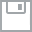
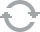
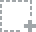
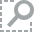
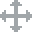
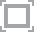
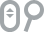
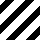
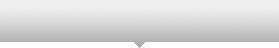
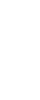
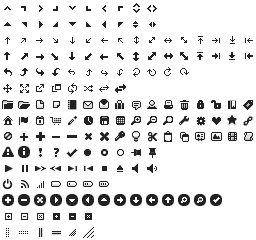
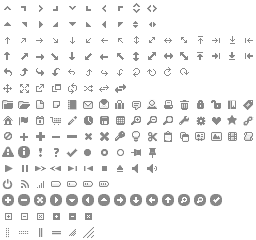
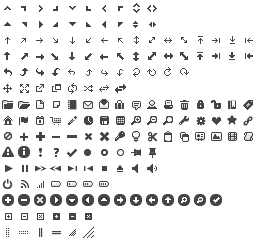
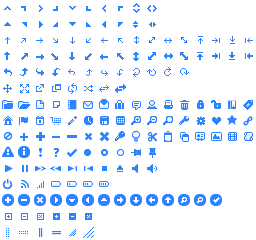
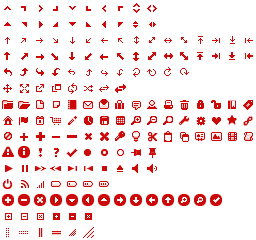
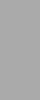
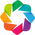
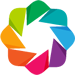

In [1]:
import math
import json
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import *

#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.io import output_notebook
output_notebook()

from sklearn.decomposition import PCA

import folium

# I. Table de données brutes

- ## Chargement des données :

***Dans cette étape, on va fusionner les deux bases de données (celle d'apprentissage et celle de test), afin d'étudier les données dans leur ensemble (nous mettrons en place plusieurs techniques d'apprentissage par la suite, en distinguant bien ces deux bases, pour avoir le modèle le plus performant possible).***

In [4]:
train = pd.read_csv('../data/labeled_dataset.csv', sep = ',', index_col = 'index')
test = pd.read_csv('../data/scoring_dataset.csv', sep = ',', index_col = 'index')

#Merging des bases de train et de test pour étudier les données dans leur ensemble.
data=pd.concat([train,test])
data=data.reset_index().set_index('index')

In [6]:
#Observation de la table
train.head()

,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel
index,,,,,,,,,,,,,
0,58.0,40.0,Etudiant,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,26.0,27.0,Ouvrier,637,95,5 portes,126,3445,Renault,25750,135,667,7.840930
2,27.0,26.0,Cadre,978,136,SUV,153,986,Renault,6790,786,696,46.078889
3,22.0,8.0,Etudiant,771,96,3 portes,111,2366,Peugeot,15140,320,765,-11.048213
4,60.0,20.0,Sans emploi,758,101,3 portes,149,1441,Peugeot,12850,287,808,1.180078


- ## Description qualitative des données

Que ce soit pour la base d'apprentissage **"labeled_dataset"** ou la base de test **"scoring_dataset"**, les données contiennent 12 variables dont 10 explicites (code postal, année de naissance, marque du véhicule, profession,...).

L'index est l'identifiant de la ligne, la variable **"Benefice net annuel"** est la variable d'intérêt (ou label) que l'on cherche à estimer.

Remarque : les données fournies sont fictives (valeurs de variables changées, distribution ne reflétant pas la réalité, population, etc...), mais connotent de l'aspect métier de l'entreprise
- > salaire annuel du cadre (index 2) a un salaire de 6 790 v.s. salaire de l'étudiant (index 0) à 20 420, ce qui est possible mais peu probable dans la réalité, surtout pour un échantillon aussi petit.

***Dans ce premier traitement, nous comptons le nombre de valeurs absentes pour chaque variable. Pandas interprète comme des NaN l'absence de valeurs. Énumérons ainsi l'ensemble des NaN pour chaque variable. Nous remarquons que certaines variables sont clairsemées, voire absentes ("Benefice net annuel" a exactement 300 valeurs absentes ; ce qui est  logique puisqu'il s'agit des données à prédire).***

In [7]:
#nombre de NaN par colonnes
data.isnull().sum()

Age                                 22
Benefice net annuel                300
Categorie socio professionnelle      0
Coefficient bonus malus              0
Cout entretien annuel                0
Kilometres parcourus par mois        0
Marque                              69
Niveau de vie                        0
Prime mensuelle                     13
Salaire annuel                       0
Score CRM                            0
Score credit                         0
Type de vehicule                     0
dtype: int64

- > **Interprétation :** le dataset est globalement 'propre' et ne comporte que très peu de données manquantes. Seul un faible nombre de variables sont touchées :
    - l'Age
    - la Marque
    - la Prime mensuelle

***À présent, nous souhaitons connaître les types de chaque variable. À noter que lorsque la variable prend plusieurs types de valeurs, Python nous affiche le type "object". Nous remarquons que les variables numériques sont prédominantes en terme de présence.***

In [8]:
#type des variables
data.dtypes

Age                                float64
Benefice net annuel                float64
Categorie socio professionnelle     object
Coefficient bonus malus              int64
Cout entretien annuel                int64
Kilometres parcourus par mois        int64
Marque                              object
Niveau de vie                        int64
Prime mensuelle                    float64
Salaire annuel                       int64
Score CRM                            int64
Score credit                         int64
Type de vehicule                    object
dtype: object

- > **Interprétation :** à l'aveugle, il est possible de considérer naïvement les variables :
    - de type numérique comme de l'information à valeur quantitative
    - de type objet (ou str) comme de l'informaton à valeur catégorielle
    
    Néanmoins, il est prudent de préter attention aux données numériques qui peuvent tout aussi bien être catégorielles si notamment à valeurs dans un espace discret.

In [18]:
#nombre de valeurs uniques pour les champs :
liste_var=['Age','Benefice net annuel','Coefficient bonus malus','Cout entretien annuel',
        'Kilometres parcourus par mois','Niveau de vie','Prime mensuelle','Salaire annuel',
       'Score CRM', 'Score credit']

for variable in liste_var:
    print('La variable numérique %s prend %s valeurs uniques' %(variable,len(set(data[variable]))))


La variable numérique Age prend 96 valeurs uniques
La variable numérique Benefice net annuel prend 1300 valeurs uniques
La variable numérique Coefficient bonus malus prend 88 valeurs uniques
La variable numérique Cout entretien annuel prend 405 valeurs uniques
La variable numérique Kilometres parcourus par mois prend 628 valeurs uniques
La variable numérique Niveau de vie prend 1186 valeurs uniques
La variable numérique Prime mensuelle prend 80 valeurs uniques
La variable numérique Salaire annuel prend 1144 valeurs uniques
La variable numérique Score CRM prend 109 valeurs uniques
La variable numérique Score credit prend 723 valeurs uniques


#### II. Analyses simples des données

- ## Etude descriptive de la donnée

***À présent, faisons de la statistique descriptive basique sur nos donnnées (moyenne, écart-type, quartiles, etc). Nous remarquons que l'individu moyen a un véhicule âgé d'environ 16 mois, qu'il a 33 ans, qu'il a le permis depuis 13 ans, un véhicule de puissance fiscale raisonnable (autour de 6-7), etc. En clair, l'individu moyen correspond au trentenaire conducteur expérimenté, et détenteur d'un véhicule récent et de prix raisonnable. Notez que pour certaines variables, certains quartiles n'existent pas en raison de la forte hétégorénéité dans la répartition des valeurs prises par les variables (exemple pour les années de naissance). Notez également que certaines valeurs sont probablement le fruit d'erreurs de la part de la MAIF (exemple du permis de conduire le plus récent qui date de 2018).***

In [5]:
#Description de la table
data.describe()

,anc_veh,annee_naissance,annee_permis,crm,kmage_annuel,prime_tot_ttc,puis_fiscale,var1,var10,var11,var12,var13,var15,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var9
count,330000.000000,329693.000000,329693.000000,330000.000000,330000.000000,300000.000000,330000.000000,329693.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000,330000.000000
mean,16.206209,1983.684949,2003.050847,73.345639,7363.165261,346.063566,6.821433,12.949153,170.543597,16.243209,1251.887476,4.225615,1.281942,1.586276,24.194133,0.542385,2.930097,0.531194,0.906300,1.105503,328.910303,1.253267,1.422579,97.710342
std,24.699703,6.563537,6.590561,23.614768,3086.819353,119.870510,2.634030,6.590561,33.779998,24.700116,369.508335,1.022597,1.173524,0.964793,4.655672,1.092848,1.464207,0.499027,0.291411,1.257861,49.520250,1.656315,0.493970,37.171880
min,0.000000,1925.000000,1944.000000,50.000000,282.000000,94.780000,0.000000,-2.000000,0.000000,0.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,272.000000,0.000000,1.000000,0.000000
25%,1.000000,1980.000000,1999.000000,50.000000,6387.000000,262.050000,5.000000,8.000000,160.000000,1.000000,1020.000000,3.000000,0.000000,1.000000,21.000000,0.000000,2.000000,0.000000,1.000000,0.000000,272.000000,0.000000,1.000000,71.000000
50%,2.000000,1985.000000,2004.000000,68.000000,6928.000000,323.220000,6.000000,12.000000,174.000000,2.000000,1200.000000,5.000000,1.000000,1.000000,24.000000,0.000000,3.000000,1.000000,1.000000,1.000000,372.000000,1.000000,1.000000,90.000000
75%,31.000000,1989.000000,2008.000000,95.000000,7467.000000,407.500000,8.000000,17.000000,188.000000,32.000000,1394.000000,5.000000,2.000000,2.000000,27.000000,1.000000,4.000000,1.000000,1.000000,2.000000,372.000000,2.000000,2.000000,115.000000
max,99.000000,1998.000000,2018.000000,270.000000,17102.000000,1518.810000,58.000000,72.000000,548.000000,99.000000,3250.000000,5.000000,9.000000,5.000000,45.000000,34.000000,5.000000,1.000000,1.000000,60.000000,372.000000,9.000000,2.000000,620.000000


***Regroupons les véhicules selon leurs marques de fabrique pour voir quels sont les véhicules les plus prisés des utilisateurs MAIF. Cela peut paraître inutile, mais pour chaque voiture, nous affichons également le nombre de valeurs prises par chaque variable, car en plus de l'absence de "prime_tot_ttc" pour les données de test, d'autres variables sont clairsemées, et nous ne connaissons donc pas les valeurs qu'elles prennent pour certains véhicules. Nous remarquons que les voitures qui ont le plus la cote sont "Citroën", "Wolkswagen", "Toyota". Les marques "BMW" et "Audi" ne sont pas aussi bien représentées que les précédentes, mais elles ont tout de même un nombre important de clients. Juste après, nous retrouvons "Volvo", etc. Les autres marques, soit plus modestes, soit de collection, soit très élitistes en termes de prix d'achat, se partagent les quelques clients restants.***

In [6]:
#Regroupement des données par marque de véhicules
data.groupby('marque').count()

,anc_veh,annee_naissance,annee_permis,codepostal,crm,energie_veh,kmage_annuel,prime_tot_ttc,profession,puis_fiscale,var1,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var6,var7,var8,var9
marque,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACMA,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
ALFA ROMEO,2209,2209,2209,2209,2209,2209,2209,2079,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209,2209
ALPINE RENAULT,22,22,22,22,22,22,22,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
AMC,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AMPHICAR,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ARO,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
ASIA,11,11,11,11,11,11,11,6,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
ASTON MARTIN,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
AUDI,6168,6168,6168,6168,6168,6168,6168,5603,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168,6168


- ## Analyse en composantes principales

***L'analyse en composantes principales qui va suivre est une analyse assez brute, car elle fait abstraction des variables qui nous posent problème, dans la mesure ou ces dites variables sont qualitatives ou contiennent des NaN. Notons que nous considérerons certaines variables comme qualitatives bien qu'elles prennent des valeurs entières ou décimales. En effet, si nous prenons par exemple le code postal : techniquement, les valeurs prises sont quantitatives, mais en réalité, elles traduisent un positionnement géographique ; donc elle ne peut pas réellement constituer une vraie variable quantitative (la considérer telle quelle fausserait l'analyse en composantes principales). Nous pourrions même aller plus loin et considérer que certaines variables quantitatives ayant un nombre de modalités relativement réduit sont en réalité des variables qualitatives, mais nous n'irons pas jusque là pour cette simple analyse en composantes principales.*** 

In [7]:
#Nous faisons volontairement une deep copy de notre table originale, et nous fairons l'ACP sur cette copie. Une simple
#affectation de notre table à une nouvelle table ne suffit pas (sans une deep copy, les traitements opérés sur la copie
#sont également opérés sur la table originale, ce que nous ne voulons pas car nous souhaitons préserver la table
#originale.

new_table=data.copy(deep=True)

#Supprimons à présent les variables qualitatives et les variables non exclusivement quantitatives.

for element in ["marque","codepostal","energie_veh","profession","var6","var7","var8","var14","var16"]:
    del new_table[element]

#Suppression des NaN comme ce qui était annoncé précédemment.
new_table_2=new_table.dropna(axis=0,how='any')

***À présent, réalisons notre ACP sur les 24 variables restantes, en affichant les ratios de variance expliquée, et en les passant au logarithme décimal. En effet, en raison de la faiblesse (voire même l'extrême faiblesse pour certaines variables) des valeurs prises par les variables en sortie de l'ACP, nous n'arrivons pas à lire grand chose sur l'histogramme de variance expliquée si nous ne passons pas au logarithme.***

In [8]:
#ACP
pca=PCA(n_components=24)
print(pca.fit(new_table_2))
pca.explained_variance_ratio_
s=np.log10(pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


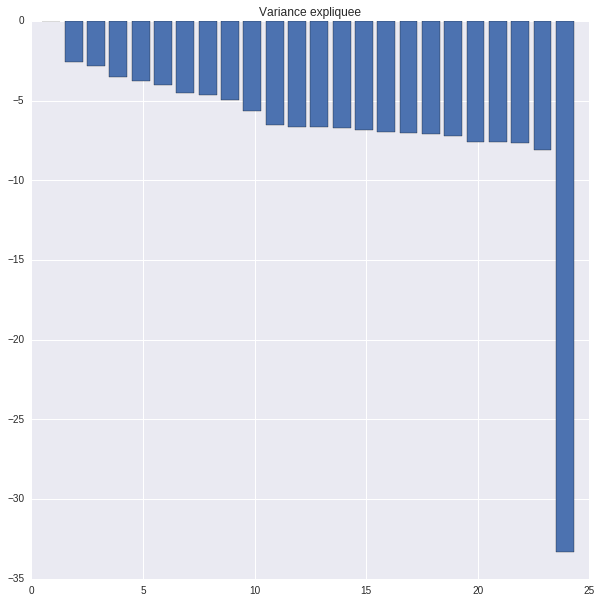

In [9]:
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(s))+0.5, s)
plt.title("Variance expliquee")

***Avant d'interpréter cet histogramme, rappelons que les valeurs sont rangés de gauche à droite de manière décroissante, et que la fonction $:X \mapsto log(X)$ est croissante sur $\mathbb{R}^{+*}$. En conséquence, on remarque que la première variable explique à elle seule la très grande majorité de la variance du modèle, que les 22 autres se partagent plus ou moins équitablement le reste de la variance expliquée (ce n'est pas réellement un partage, mais la décroissance de la variance expliquée n'est pas extrêmement marquée). Enfin, la 24ème variable n'a pas son mot à dire vu la variance expliquée par les 23 autres, et vu qu'elle est à peine plus grande que la longueur de Planck. Toutefois, une des limites de l'ACP est que nous ne savons pas quelles sont les variables concernées. Il faudrait pousser l'étude plus loin avec d'autres techniques, mais ce n'est pas utile ici.***

# III. Data visualisation

- ## Etude de certains champs

***Dans un premier temps, nous allons voir comment les marques sont répandues. Nous ne prenons que les 50 marques les plus répandues, et nous affectons le reste des marques à la catégories 'AUTRES'. Cela va nous permettre par la suite d'afficher un premier diagramme pour voir quelles sont les marques principales les plus populaires.***

 - -    **Marques des véhicules**

In [10]:
best = data.marque.value_counts().head(50)
data['marque']=data.marque.map(lambda x : x if x in best else 'AUTRES' )

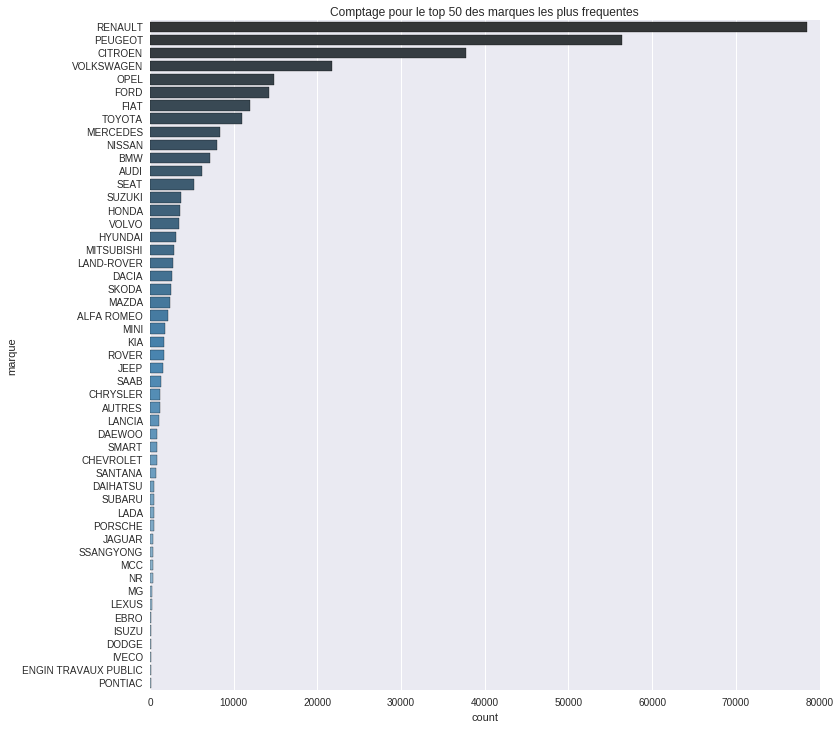

In [11]:
plt.figure(figsize=(12,12))
sns.set(style="darkgrid")
ax = sns.countplot(y="marque", order=data['marque'].value_counts().index,data=data,palette='Blues_d')
ax.set_title('Comptage pour le top 50 des marques les plus frequentes')

- - **Age**

***Nous allons récupérer l'âge qui est une donnée plus parlante que l'année de naissance et l'année actuelle, pour l'étude des individus.***

In [12]:
data['age']=datetime.now().year-data['annee_naissance']
#data['age'].apply(lambda x : int(x))
del data['annee_naissance']

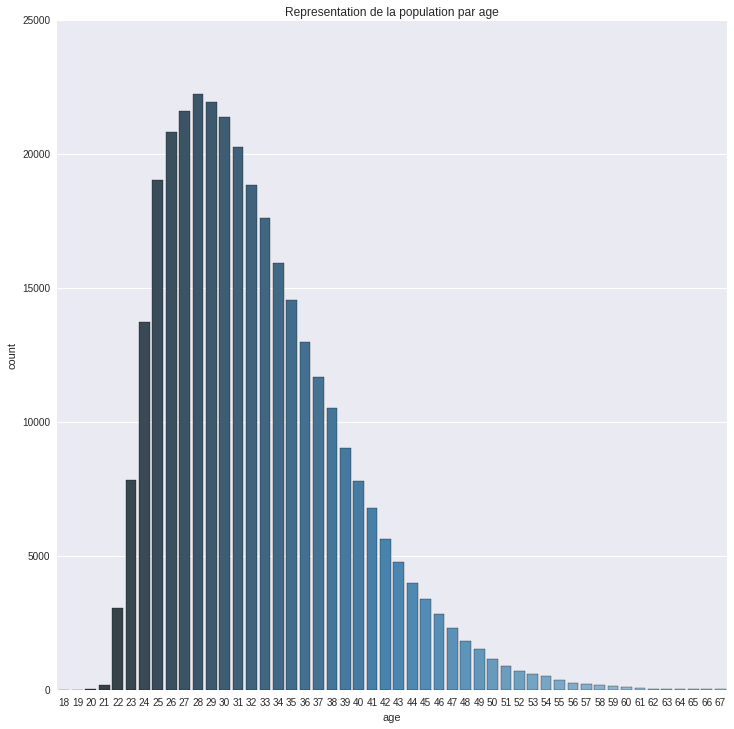

In [13]:
plt.figure(figsize=(12,12))
l=[int(i) for i in list(data['age'].value_counts().sort_index().index)]
sns.set(style="darkgrid")
ax = sns.countplot(x="age", order=data['age'].value_counts().sort_index().index[0:50],data=data,palette='Blues_d')
ax.set_title('Representation de la population par age')
ax.set_xticklabels(l)
ax

***Cet histogramme nous donne la représentation des différentes générations au sein de la clientèle de la MAIF. Comme ce que nous avions dit récemment, l'individu moyen est proche de la trentaine. La tranche 24-39 ans constitue la très grande majorité de la clientèle de la MAIF. Cette répartition nous rappelle un peu la répartition d'une distribution d'une loi Gamma aux paramètres bien particuliers (cela s'en approche, mais je vous accorde que cela ne colle pas exactement à une loi Gamma).***

- - **Ancienneté du permis de conduire**

***De même que précédemment, nous préférons parler d'ancienneté du permis plutôt que de l'année d'obtention, car ceci est plus parlant pour nos études.***

In [14]:
data['anciennete_permis']=datetime.now().year-data['annee_permis']
del data['annee_permis']

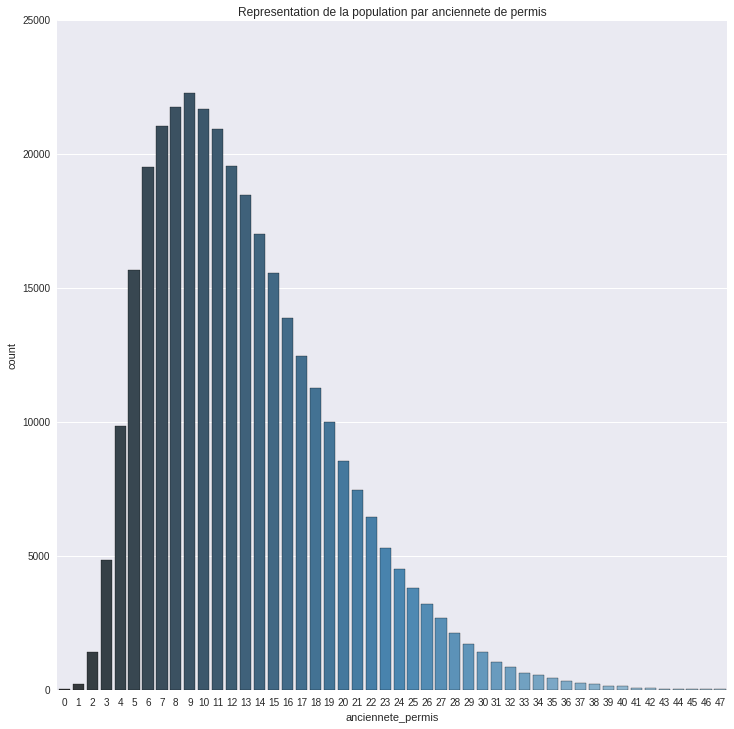

In [15]:
plt.figure(figsize=(12,12))
l=[int(i) for i in list(data['anciennete_permis'].value_counts().sort_index().index)]
sns.set(style="darkgrid")
ax = sns.countplot(x="anciennete_permis", order=data['anciennete_permis'].value_counts().sort_index().index[2:50],
                   data=data,palette='Blues_d')
ax.set_title('Representation de la population par anciennete de permis')
ax.set_xticklabels(l[2:50])
ax

***Cet histogramme nous donne la représentation des différentes anciennetés de permis au sein de la clientèle de la MAIF. Comme ce que nous avions dit récemment, l'individu moyen a une dizaine d'années de permis au compteur. La très grande majorité de la clientèle de la MAIF a entre 4 et 20 ans de permis. Cette répartition nous rappelle un peu la répartition d'une distribution d'une loi Gamma aux paramètres bien particuliers (cela s'en approche, mais je vous accorde que cela ne colle pas exactement à une loi Gamma).***

- - **Code postal -> département**

***La variable "code_postal" est à traiter comme une variable catégorielle. Cela rejoint notre raisonnement précédent, de par l'interprétation géographique de cette variable.

In [16]:
#regroup by postal county
#data['codepostal_']=data['codepostal'].apply(lambda x : str(x)[0:2])
data['codepostal_']=data['codepostal'].astype(str).apply(lambda x : x[0:2] if len(x)>4 else x[0:1].zfill(2))
del data['codepostal']

In [17]:
overall_ind=data.groupby('codepostal_').count().reset_index()[['codepostal_','anc_veh']]
overall_ind['count']=overall_ind['anc_veh']
del overall_ind['anc_veh']

with open('data/france-geojson-master/departements.geojson') as data_file:    
    data_ = json.load(data_file)
l_dep=[]    
for feature in data_['features']:
    l_dep.append(feature['properties']['code'])
l=[]
for element in l_dep:
    l.append(str(element))
l_missing=[]
for element in l:
    if str(element) not in list(overall_ind['codepostal_']):
        l_missing.append(element)
        
#create 0 list
empty=[0] * len(l_missing)
df=pd.DataFrame()
df['codepostal_']=l_missing
df['count']=empty

test_=pd.concat([overall_ind,df],axis=0)


state_geo = 'data/france-geojson-master/departements.geojson'

#Let Folium determine the scale
map_ = folium.Map(location=[45.7517,4.9106], zoom_start=5.5)
map_.choropleth(geo_path=state_geo, data=test_,
             columns=['codepostal_', 'count'],
             key_on='feature.properties.code',
             fill_color='PuRd',fill_opacity=0.8, line_opacity=0.2,
             legend_name='Répartition geographiques des assures (%)')
map_

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


***Note : la légende indiquant -240 signifie en réalité inférieure stricte à 240. Ce n'est pas la valeur négative -240 (cela n'aurait pas de sens), comme on va le montrer sur le plot suivant.***

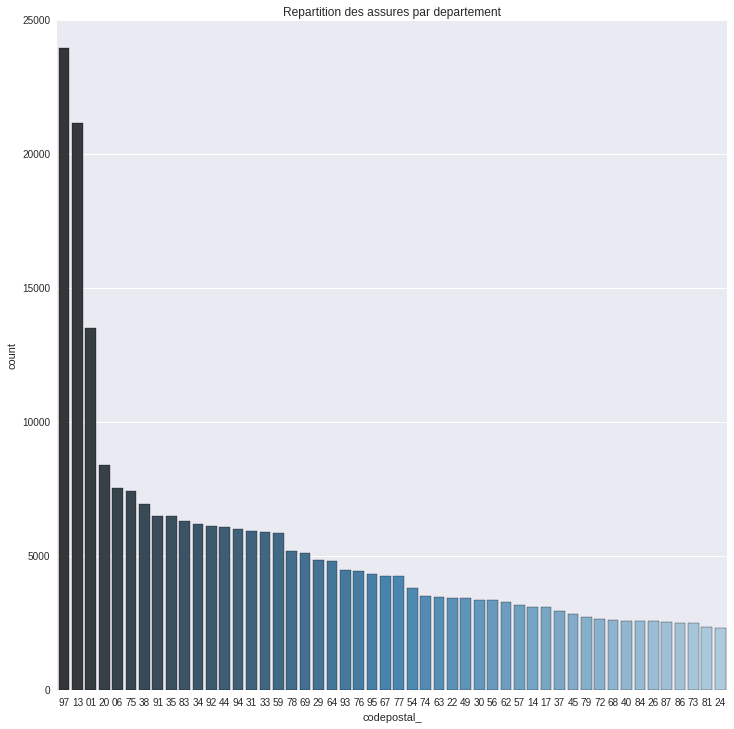

In [18]:
plt.figure(figsize=(12,12))
sns.set(style="darkgrid")
ax = sns.countplot(x="codepostal_", order=data['codepostal_'].value_counts().index[0:50],data=data,palette='Blues_d')
ax.set_title('Repartition des assures par departement')

***Nous remarquons que les départements d'outre-mer, au même titre que les Bouches-du-Rhône et l'Ain sont sur-représentés. Une telle représentation peut paraître illogique, mais cela ne reste qu'un modeste a priori. Pour être certain de ce que nous avançons, il nous faudrait bien plus que les données de 330 000 clients MAIF. Peut-être qu'avec l'intégralité des données, nous retrouverons encore cette répartition surprenante (où la majorité des clients MAIF sont en outre-mer), ou peut-être que nous aurons une répartition plus homogène, ou une majorité de clients en Île-de-France, ou autre. En somme, difficile de statuer avec seulement 330 000 clients. En effet, la MAIF couvrait plus de 7 millions de personnes fin 2015 (chiffres publics : résultats 2015 du groupe MAIF), et il y a fort à parier qu'une forte proportion de ces 7 millions d'adhérents (et pas seulement 330 000 d'entre eux) sont couverts pour leur automobile.***

- - **Energie**

***Représentons la répartition du type de carburant utilisé par les clients de la MAIF. Nous remarquons que le diesel et l'essence se taillent la part du lion.***

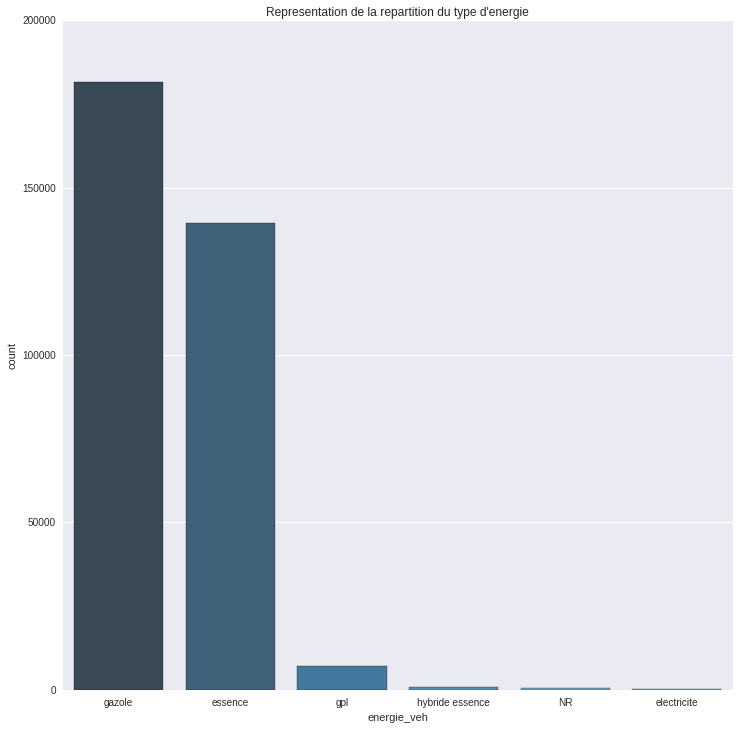

In [19]:
plt.figure(figsize=(12,12))
sns.set(style="darkgrid")
ax = sns.countplot(x="energie_veh", order=data['energie_veh'].value_counts().index,data=data,palette='Blues_d')
ax.set_title("Representation de la repartition du type d'energie")

- - **Profession**

***Représentons la répartition des professions des clients de la MAIF. Les professions les plus répandues sont en tête "enseignant, formateur, chercheur", puis ensuite les professions "agent, employé", et enfin les professions "cadre, ingénieur". Pour les autres professions, elles restent minoritaires. Nous pourrions montrer qu'il existe une corrélation entre certaines "classes sociales" et certaines marques de voiture. En effet, les professions les plus répandues se retrouvent a minima au sein de la classe moyenne de la population (classe dans laquelle nous retrouvons les véhicules les plus répandus), et les moins répandus comme chef d'entreprise se retrouvent (entre autres) parmi les personnes les plus fortunées (qui roulent avec des véhicules moins répandus, comme Aston Martin, ou autre).***

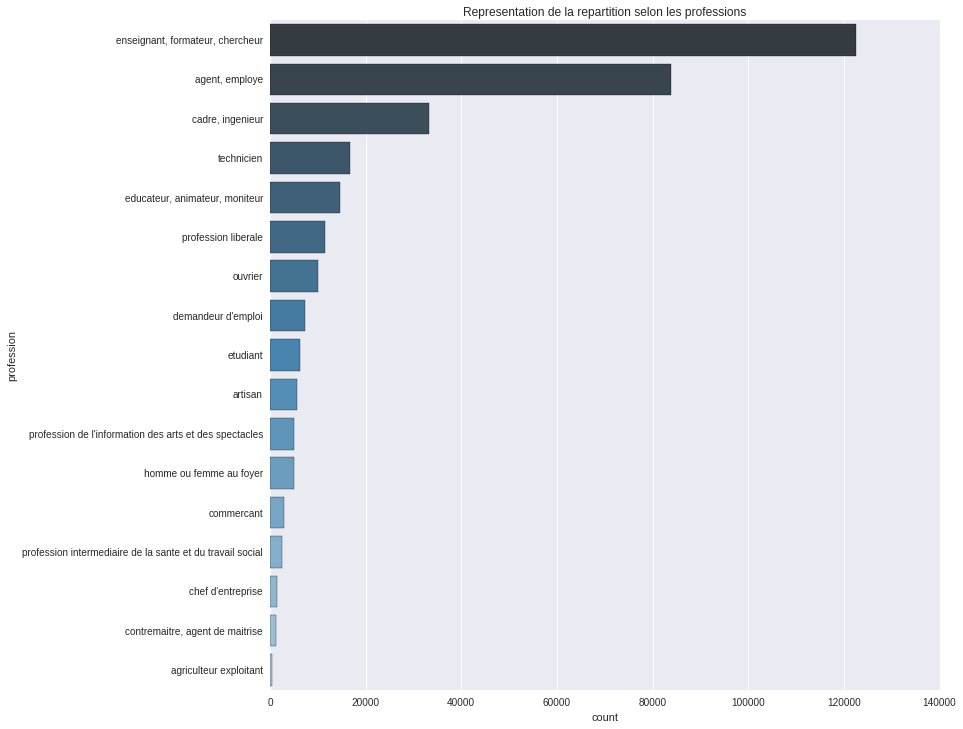

In [20]:
plt.figure(figsize=(12,12))
sns.set(style="darkgrid")
ax = sns.countplot(y="profession", order=data['profession'].value_counts().index,data=data,palette='Blues_d')
ax.set_title("Representation de la repartition selon les professions")

# IV. Gestion des données manquantes et des variables catégorielles

- ## Gestion des données manquantes :

***Ici, nous répertorions les variables où des données sont manquantes. Nous retrouvons ainsi les quatre variables "prime_tot_ttc", "var1", "age", et "anciennete_permis".***

In [21]:
#Vérifier les colonnes concernées [possédant des NaN]
for element in data.isnull().sum().index:
    if data[element].isnull().sum()!=0:
        print (element)

prime_tot_ttc
var1
age
anciennete_permis


***Maintenant que nous savons quelles données sont manquantes, nous mettons en place une première stratégie : nous colmatons ce clairsemage par les valeurs médianes.***

In [22]:
data_raw01=data.copy(deep=True)
%store data_raw01

Stored 'data_raw01' (DataFrame)


In [23]:
# Première approche : remplacer les valeurs manquantes par la médiane pour les variables quantitatives
median_age = data.age.median()
median_anc_permis = data.anciennete_permis.median()
mean_var1=data.var1.mean()
data['age'] = data.age.fillna(median_age)
data['anciennete_permis'] = data.anciennete_permis.fillna(median_anc_permis)
data['var1'] = data.var1.fillna(mean_var1)

data_raw02=data.copy(deep=True)

In [24]:
#Nous stockons cette nouvelle table (intitulée "data_raw"), pour l'utiliser ultérieurement dans un autre Notebook.
%store data_raw02

Stored 'data_raw02' (DataFrame)


- ## Encodage complet disjonctif (dummisation)

***Nous constituons une liste des variables dont les valeurs sont de types multiples. Pour rappel, de telles variables sont dites de type "object".***

In [25]:
#Vérifier les colonnes qui sont de type objet
g = data.columns.to_series().groupby(data.dtypes).groups
list_categorical=g[g.keys()[0]]
list_categorical_=list(list_categorical)
list_categorical_.remove('codepostal_')

***Notre programme nous annonce donc que les variables "var7" et "var16" sont des variables de type "object" (comme ce qui a été vu au début de ce Notebook).***

In [26]:
#Dummisation

"""Attention, l'option drop_first = True permet de ne conserver que les (k-1) modalités, évitant ainsi d'avoir des
colonnes linéairement dépendantes. En effet, il est facile de déterminer la k-ième modalité en fonction des (k-1) autres.

Cette option a toute son importance dans le calcul de la régression linéaire.

Cette option est inédite dans la version de Pandas 0.18 (elle n'existait pas auparavant)."""

data = pd.get_dummies(data, columns=list_categorical_,drop_first=True)
data.shape

(330000, 154)

- ## Clustering des assurés :

***Enfin, nous allons essayer de créer des groupes d'individus aux caractéristiques communes ; des groupes qui pourraient décrire les différents types de sociétaires automobiles que nous pouvons rencontrer à la MAIF.***

In [27]:
from sklearn.cluster import KMeans
import sklearn.metrics as sm
 
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

***Optimisation combinatoire : partitionnement en k-moyennes.***

In [28]:
# k-means cluster
data_clus=data.copy(deep=True)
del data_clus['prime_tot_ttc']
del data_clus['codepostal_']
model = KMeans(n_clusters=3)
model.fit(data_clus)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

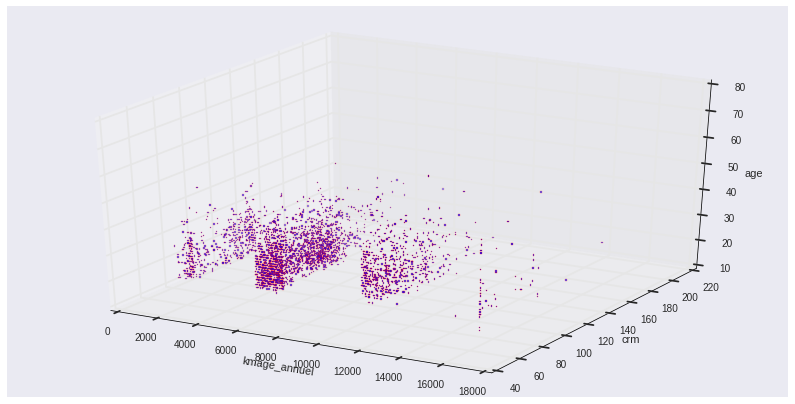

In [29]:
from mpl_toolkits.mplot3d import Axes3D
sample=data.sample(n=3000)
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')
colormap = np.array(['blue','yellow','red', 'lime', 'orange'])
ax.scatter(sample['kmage_annuel'],sample['crm'],sample['age'],color=colormap[model.labels_],
           marker=',',depthshade=True,s=2)

ax.set_xlabel('kmage_annuel')
ax.set_ylabel('crm')
ax.set_zlabel('age')

plt.show()

***Au vu des clusters résultant, les résultats ne semblent pas suffisamment concluants pour les trois axes que nous avons choisis.***

In [30]:
#Cette commande nous permet de charger la variable data, et de la stocker pour l'exploiter dans un autre Notebook.
%store data

Stored 'data' (DataFrame)
